# Implementation 02 (SNOPT)
`1011.30.Mar.20`

Now that I have the constraints set up (Both the new boundary and the function determining if a turbine is "in"), I can try and feed that into [SNOPT](https://web.stanford.edu/group/SOL/snopt.htm) to actually get an optimization. I will also need to use  SNOPT for my old system as well.

### Setting up my desktop

`1255.01.Apr.20`

I had some trouble finding examples of implementation code.
I today reached out to PJ and he gave some sample code.
I'm going over it now.

#### PJ's code

```python
from pyoptsparse import Optimization, SNOPT, pyOpt_solution, NSGA2
import numpy as np
import matplotlib.pyplot as plt
from position_constraints import *
from windRoses import *
from grid_param_test import *
from aep_calc import *
import scipy as sp
import os
import sys
sys.dont_write_bytecode = True
def obj_func_grid(xdict):
    global rotorDiameter
    global turbineZ
    global windDirections
    global windSpeeds
    global windFrequencies
    global shearExp
    global minSpacing
    global nTurbs
    global boundaryVertices
    global boundaryNormals
    global circle_radius
    global rf
    global wakemodel
    global nRows
    global turbs_per_row
    global x_start
    global anchor_x
    global anchor_y
    global nCalls
    nCalls += 1
    dx = xdict['dx']
    dy = xdict['dy']
    offset = xdict['offset']
    rotate = xdict['rotate']
    # scale = xdict['scale']
    scale = 1.0
    turbineX,turbineY = makeGrid_centered(dx,dy,offset,rotate,turbs_per_row,x_start)
    if nCalls == 1:
        print turbineX
        print turbineY
    show = False
    if show == True:
        plt.figure(1)
        plt.clf()
        for i in range(nTurbs):
            circ = plt.Circle((turbineX[i],turbineY[i]), rotorDiameter[i]/2.,facecolor="blue",edgecolor="blue",alpha=0.2)
            plt.gca().add_patch(circ)
        # circ = plt.Circle((0.,0.), circle_radius,facecolor="None",edgecolor="black",alpha=0.8)
        # plt.plot(np.array([-1800.,-1800.,1800.,1800.,-1800]),np.array([-1800.,1800.,1800.,-1800.,-1800.]),'-k')
        # plt.gca().add_patch(circ)
        # plt.xlim(-2200.,2200.)
        xb = boundaryVertices[:,0]
        yb = boundaryVertices[:,1]
        xb = np.append(xb,xb[0])
        yb = np.append(yb,yb[0])
        plt.plot(xb,yb,'--k')
        plt.axis('equal')
        plt.axis('off')
        plt.draw()
        plt.pause(0.001)
    funcs = {}
    AEP = fast_calc_AEP(turbineX, turbineY, turbineZ, rotorDiameter, windDirections,
                windSpeeds, windFrequencies, wakemodel=wakemodel,relaxationFactor=rf)
    print -AEP/1.E5
    funcs['obj'] = -AEP/1.E5
    funcs['sep'] = SpacingConstraint(turbineX, turbineY, rotorDiameter, minSpacing=minSpacing)/1.E5
    bounds = arbitraryBoundary(turbineX, turbineY, boundaryVertices, boundaryNormals)/1.E3
    b = np.zeros(np.shape(bounds)[0])
    for i in range(len(b)):
        b[i] = min(bounds[i])
    funcs['bound'] = b
    fail = False
    return funcs, fail
## Main
if __name__ == "__main__":
    global rotorDiameter
    global turbineZ
    global windDirections
    global windSpeeds
    global windFrequencies
    global shearExp
    global minSpacing
    global nTurbs
    global boundaryVertices
    global boundaryNormals
    global circle_radius
    global rf
    global wakemodel
    global nRows
    global turbs_per_row
    global x_start
    global anchor_x
    global anchor_y
    global nCalls
    wakemodel = "gaussian"
    nTurbs = 100
    rose = 'ukiah'
    windDirections, windFrequencies, windSpeeds = ukiahRose(30)
    wind_angle = windDirections[np.argmax(windFrequencies)]
    windDirections, windFrequencies, windSpeeds = ukiahRose(30,nSpeeds=8)
    windDirections -= wind_angle
    turbineZ = np.ones(nTurbs)*100.
    rotorDiameter = np.ones(nTurbs)*130.
    shearExp = 0.15
    minSpacing = 2.0
    maxAEP = 0.
    spacing = 4.
    side_length = (np.sqrt(nTurbs)-1.)*rotorDiameter[0]*spacing
    a = side_length**2
    circle_radius = np.sqrt(a/np.pi)
    # folder = 'grid_square_%s_%s_%s_%s'%(nTurbs,spacing,rose,wakemodel)
    # folder = 'grid4_square_%s_%s_%s_%s'%(nTurbs,spacing,rose,wakemodel)
    #
    # if not os.path.exists(folder):
    #     os.makedirs(folder)
    """circle boundary"""
    nBounds = 20
    # circle_radius = 5280.
    xBounds = np.zeros(nBounds)
    yBounds = np.zeros(nBounds)
    theta = np.linspace(0.,2.*np.pi-2.*np.pi/float(nBounds),nBounds)
    for i in range(nBounds):
        xBounds[i] = circle_radius*np.cos(theta[i])
        yBounds[i] = circle_radius*np.sin(theta[i])
    x = np.zeros_like(xBounds)
    x[:] = xBounds[:]
    y = np.zeros_like(yBounds)
    y[:] = yBounds[:]
    xBounds = x*np.cos(np.deg2rad(wind_angle)) - y*np.sin(np.deg2rad(wind_angle))
    yBounds = x*np.sin(np.deg2rad(wind_angle)) + y*np.cos(np.deg2rad(wind_angle))
    """square boundary rotated 30 deg from dominant wind direction"""
    # nBounds = 4
    # x = np.array([-side_length/2.,side_length/2.,side_length/2.,-side_length/2.])
    # y = np.array([-side_length/2.,-side_length/2.,side_length/2.,side_length/2.])
    # xBounds = x*np.cos(np.deg2rad(30.)) - y*np.sin(np.deg2rad(30.))
    # yBounds = x*np.sin(np.deg2rad(30.)) + y*np.cos(np.deg2rad(30.))
    # locations = np.zeros((nBounds,2))
    # locations[:, 0] = xBounds
    # locations[:, 1] = yBounds
    # boundaryVertices, boundaryNormals = calculate_boundary(locations)
    """amalia boundary"""
    # locations = np.loadtxt('layout_amalia.txt')
    # xBounds = locations[:, 0]
    # yBounds = locations[:, 1]
    # xBounds = xBounds - min(xBounds) - (max(xBounds)-min(xBounds))/2.
    # yBounds = yBounds - min(yBounds) - (max(yBounds)-min(yBounds))/2.
    # locations[:, 0] = xBounds
    # locations[:, 1] = yBounds
    # boundaryVertices, boundaryNormals = calculate_boundary(locations)
    # xBounds = boundaryVertices[:, 0]
    # yBounds = boundaryVertices[:, 1]
    nBounds = len(xBounds)
    points = np.zeros((nBounds,2))
    points[:, 0] = xBounds
    points[:, 1] = yBounds
    # hull = sp.spatial.ConvexHull(points)
    # area = hull.volume
    # area_ratio = area/(np.pi*circle_radius**2)
    # xBounds = xBounds/np.sqrt(area_ratio)
    # yBounds = yBounds/np.sqrt(area_ratio)
    # points[:, 0] = xBounds
    # points[:, 1] = yBounds
    # boundaryVertices, boundaryNormals = calculate_boundary(points)
    xBounds = np.append(xBounds,xBounds[0])
    yBounds = np.append(yBounds,yBounds[0])
    dx_start,dy_start,offset_start,rotate_start,turbs_per_row,x_start = make_start_grid_test(nTurbs,boundaryVertices,boundaryNormals)
    factors = np.array([3.0,2.75,2.5,2.25,2.0,1.75,1.5,1.25,1.0])
    rf = 1.0
    num = 1
    nCalls = 0
    for i in range(num):
        print 'iterations: ', i
        # dx = float(np.random.rand(1))*dx_start+200.
        # dy = float(np.random.rand(1))*dy_start+200.
        # offset = float(np.random.rand(1))*25.+10.
        # rotate = float(np.random.rand(1))*30.-15.
        dx = dx_start
        dy = dy_start
        offset = offset_start
        rotate = rotate_start
        input = {'dx':dx,'dy':dy,'offset':offset,'rotate':rotate}
        funcs,_ = obj_func_grid(input)
        AEPstart = funcs['obj']
        print AEPstart
        nCalls = 0
        """Optimization"""
        optProb = Optimization('Wind_Farm_AEP', obj_func_grid)
        optProb.addObj('obj')
        optProb.addVar('dx', type='c', lower=0., upper=None, value=dx)
        optProb.addVar('dy', type='c', lower=0., upper=None, value=dy)
        optProb.addVar('offset', type='c', lower=None, upper=None, value=offset)
        optProb.addVar('rotate', type='c', lower=None, upper=None, value=rotate)
        num_cons_sep = (nTurbs-1)*nTurbs/2
        optProb.addConGroup('sep', num_cons_sep, lower=0., upper=None)
        optProb.addConGroup('bound', nTurbs, lower=0., upper=None)
        opt = SNOPT()
        opt.setOption('Scale option',0)
        opt.setOption('Iterations limit',1000000)
        opt.setOption('Summary file','summary_grid.out')
        opt.setOption('Major optimality tolerance',1.e-5)
        opt.setOption('Major feasibility tolerance',1.e-6)
        res = opt(optProb)
        dx_f = res.xStar['dx']
        dy_f = res.xStar['dy']
        o_f = res.xStar['offset']
        r_f = res.xStar['rotate']
        # print 'dx_f: ', dx_f
        # print 'dy_f: ', dy_f
        # print 'offset_f: ', o_f
        # print 'rotate_f: ', r_f
        print nCalls
        input = {'dx':dx_f,'dy':dy_f,'offset':o_f,'rotate':r_f}
        funcs,_ = obj_func_grid(input)
        separation = min(funcs['sep'])
        boundary = min(funcs['bound'])
        if separation > -1.E-4 and boundary > -1.E-4 and -funcs['obj'] > maxAEP:
            maxAEP = -funcs['obj']
        if separation > -1.E-4 and boundary > -1.E-4:
            print 'AEP opt: ', -funcs['obj']
            # file = open('%s/AEP.txt'%folder, 'a')
            # file.write('%s'%(-funcs['obj']) + '\n')
            # file.close()
            #
            # file = open('%s/funcCalls.txt'%folder, 'a')
            # file.write('%s'%nCalls + '\n')
            # file.close()
        print 'maxAEP: ', maxAEP
    print 'final maxAEP: ', maxAEP
    plt.show()
```

### More work

`1357.01.Apr.20`

I had an issue with installing pyOptSparse - I thought I had on monday, but apparently not.
I think the issue was I installed Python 3 on this windows machine, but the FLOWLab only works in Python 2, so I needed to install that and change the environment with `activate py2` and `deactivate`.
It's completing the installation now, we'll see if it worked.

`1307.03.Apr.20`

I had to restart my system and apparently lost the last few days of logs, but it wasn't much. I've been trying to install SNOPT on my windows system and it just isn't working. I've got to call it at this point and move over to my laptop for working.

`1419.03.Apr.20`

I prefer my keyboard, mouse, and monitor, and the laptop just can't connect to all those devices. Instead of buying yet another adapter, I opted to go with Chrome's remote desktop extension. It allows me to remote in to the macbook (there's a bit of lag), but I can code and run everything on here, while still using my main desktop for internet, background music, and everything else.

## Order of Events

Ok I have the constraint functions set, I want to do 3 things from here out:

1. Get SNOPT to optimize the smaller Dr. Ning area
2. Get SNOPT to optimize my original full area
3. Get my mapping algorithm working

## SNOPT on Dr. Ning's area

`0834.06.Apr.20`

First I'll need to run the test files that wouldn't work on my desktop.

`1259.08.Apr.2020`

After conversing with Dr.~Ning, he told me since the lab has an old version of SNOPT, I need to retrograde and download an old version of [PyOptSparse](www.github.com/mdolab/pyoptsparse). After looking through the release history I installed [v1.2](https://github.com/mdolab/pyoptsparse/releases/tag/v1.2). The NLPQLP test failed, but at least the SNOPT test finally passed, so I'll keep moving forward. This took entirely too long to figure out.

First thing to do is look at PJ's sample code that he gave me last week. (in markdowned code block below).

`1756.08.Apr.20`

I also am using a tutorial from [the pyOpt website](www.pyopt.org/tutorial).
We'll see how it works.


### Helper functions for formatting

In [67]:
#- Rip the boundary coordinates from the .yaml file and print -#
from scipy.optimize import minimize
import scipy.spatial.distance as ssd
import random

%run 'baker_cs34_functions_sandbox.py'
%run 'iea37_aepcalc.py'
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)
coordList = closeBndryList(bndryPts)    # Duplicate the first coordinate for a closed boundary

The splined boundary and the defining coordinates:


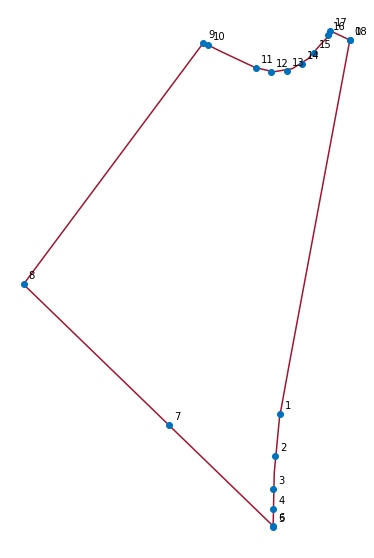

In [68]:
#-- Plot the boundary (modelled with splines) --#
displaySize = np.recarray(1, coordinate)
displaySize.x = 10
displaySize.y = 10
numLinspace = 10
numGridLines = 10                   # How many gridlines we'll use for the visualization
printOffset = (5, 5)
clsdBP = closeBndryList(bndryPts)
vertexList = [0, 6, 8, 9, 18]       # Hard code the vertices (though this could be done algorithmically)
numSides = len(vertexList) - 1      # The number of sides for our original coordinate system. Usually (4) to Euclidean, but could be any number)

scaleAEP = 1e5
scaleTurbCoord = 1e3

#-- Spline the boundary --#
splineList = np.empty(numSides, interp1d)                  # Init. array IOT save the Splines for each "side"
buf = np.zeros((numSides, numGridLines, 2))                # Used to initalize the recarray to zeros
segCoordList = np.recarray([numSides, numGridLines], dtype=coordinate, buf=buf)

#- Create the splines for each side (<numSides> many)-#
for i in range(numSides):
    BndPts = clsdBP[vertexList[i]:(vertexList[i+1]+1)]      # Extract the points for the "edge" we want
    segCoordList[i] = sliceBoundary(BndPts, numGridLines)    # Reparameterize the boundry to be defined by <numGridLines> many points
    splineList[i] = interp1d(segCoordList[i].x, segCoordList[i].y, kind='linear')   # Make the spline using NumPy's <interp1d>
    
print("The splined boundary and the defining coordinates:")
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 1)

#for i in vertexList:                         # Number the vertices
for i in range(len(clsdBP)):                         # Number the vertices
    plt.plot(clsdBP[i].x, clsdBP[i].y, 'o', color=(getPltClrs().getColor(5)))
    plt.annotate(i, (clsdBP[i].x, clsdBP[i].y), xytext=printOffset, textcoords='offset points')

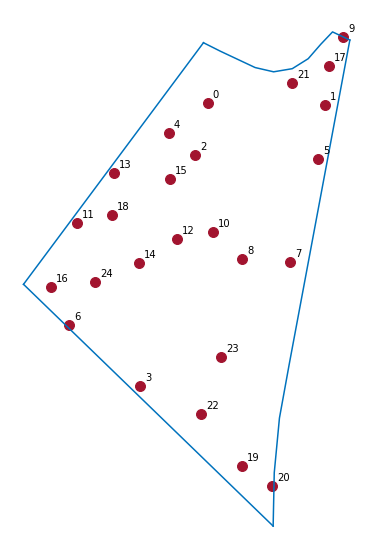

In [56]:
#-- Testing --#
numTurbs = 25
turbRandoList = iea37cs3randomstarts(numTurbs, splineList, vertexList, bndryPts, turb_diam)

#-- Print the random turbine locations (with numbers) --#
#-- Plot the boundary --#
for i in range(numSides):
    plt.hold = True
    printBoundaryArray(segCoordList[i].x, splineList[i](segCoordList[i].x), displaySize, 5)

#-- Plot the turbine locations --#
printTurbines(turbRandoList, getPltClrs().getColor(1), turb_diam/2)
for i in range(len(turbRandoList)):         # Number the turbines
    plt.annotate(i, (turbRandoList[i].x, turbRandoList[i].y), xytext=printOffset, textcoords='offset points')
#-- End print of turbine locations--#


### Retest of notebook `bakerIEA37cs3-10-cs3workout`

`1601.14.Apr.20`

The following is making sure the functions written in notebook `10` carried over when saved into the `sandbox` header file. I just call the functions and ensure they give the same output:

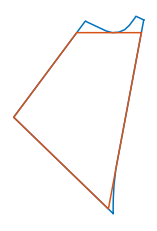

In [70]:
newVertices = makeSimpleCs3Bndry(clsdBP)
colorNum = 5
printBoundaryClr(clsdBP, colorNum)
printBoundaryClr(newVertices, colorNum+1)
#plt.savefig("./figures/ConcaveBoundary.pdf", bbox_inches='tight')

(-1.0722076220940426,
 0.8912361943135312,
 -1.0859154832602076,
 0.8042251484643573)

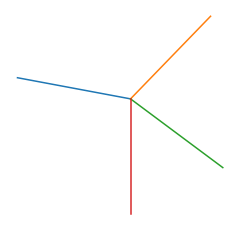

In [72]:
# Plot the Normals
BndryNormals = bndryNormals(newVertices)
for i in range(4):
    plt.plot([0,BndryNormals[i][0]], [0,BndryNormals[i][1]])

plt.axis('scaled')                      # Trim the white space
plt.axis('off')                         # Turn off the framing
#plt.savefig("./figures/FaceNormals.pdf", bbox_inches='tight')

[0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0.
 0.]


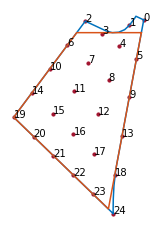

In [75]:
BndryNormals = bndryNormals(newVertices)
[faceDist, bInside] = calcDistNorms(x0s, newVertices, BndryNormals)
np.set_printoptions(suppress=True)
#print(faceDist)
print(bInside)

printBoundaryClr(clsdBP, colorNum)
#printTurbines(clsdBP, getPltClrs().getColor(5), 10) # Print the boundary verticies
printBoundaryClr(newVertices, colorNum+1)
printTurbines(x0s, getPltClrs().getColor(1), 10, True)
#plt.savefig("./figures/BoundaryNumberedTurbs.pdf", bbox_inches='tight')

### Spacing Constraint
I think there was a problem with my `checkTurbSpacing` function last time. I'll redo and check it here.

In [64]:
from math import comb   # For calculating the number of combinations

def checkTurbSpacing(x0, turb_diam):
    testCoordMat = makeCoordMatrix(x0)           # make [[x1,y1],[x2,y2],...]

    # Number will be C(numTurbs, 2) = numTurbs! / (2*(numTurbs-2)!).
    cTurbSpace = ssd.pdist(testCoordMat, metric='euclidean') # Get the distance between each turbine
    constraints = cTurbSpace - (2*turb_diam)                 # Constrain that the turbines are less than 2 diams apart
    return constraints  # Negative if ok, positive if too close

#-- Validation --#
Ax0 = makeCoordArray(turbRandoList)                # get it into a long array of [x1,y1,x2,y2,...]
consTurbSpacing = checkTurbSpacing(Ax0, turb_diam)

#- Make an array logging all pair numbers -#
nNumPairs = comb(numTurbs, 2)
sPairNames = ["" for x in range(nNumPairs)]
nCntr = 0   # Just a counter to iterate where we are
for i in range(numTurbs):
    for j in range((i+1), numTurbs):
        sPairNames[nCntr] =  str(i) + ', ' + str(j)
        nCntr = nCntr + 1

bSpacing = np.ones(nNumPairs) # Boolean array counting how many are too close
nGood = 0   # Number of close pairs
#- Check which were negative -#
for i in range(nNumPairs):
    if (consTurbSpacing[i] < 0):
        bSpacing[i] = 0
        nGood = nGood + 1

#-- Print if there are violations --#
for i in range(nNumPairs):
    if (bSpacing[i] == 0):
        print(sPairNames[i])
        print(consTurbSpacing[i])
        print()

print(nNumPairs)
print()

300
300


`0940.09.Apr.20`

`checkTurbSpacing()` works. I commented out the part of `iea37cs3randomstarts()` that checks for spacing (the last `for` loop) and then ran the check, and it popped for the correct turbine pairs. Of note, it only checks each pair once. So if turb #1 and turb #5 are too close, it only logs one violation, not two.

### Putting it all together

`0946.09.Apr.20` I've really just got to get this done.

Now that I'm sure the turbine spacing constraint works and the boundary constraint works, I've gotta code up the optimization.

`1423.09.Apr.20`

So after lab meeting, Dr.~Ning and PJ directed me to the [PyOptSparse Tutorial](https://github.com/mdolab/pyoptsparse/blob/master/doc/tutorial.rst) which instructs me how to setup the optimization. The previous ones I was looking at (with SNOPT v7 and PyOpt) were incorrect, which is why I was having problems.

They did a really smart thing I didn't know about to pass all the variables: they used a [`dict`](https://www.w3schools.com/python/python_dictionaries.asp) instead of one long string of variables. I was packing and unpacking values previously with my `optimoMakeArgTuples()` and `optimoStripArgTuples()`, but I should've just been passing the values aldeary tagges as a dictionary. Live and learn.


In [86]:
def snoptMakeArgDict(wind_dir_freq, wind_speeds, wind_speed_probs, \
                     wind_dir, turb_diam, turb_ci, turb_co, rated_ws, \
                     rated_pwr, fAEPscale, fTCscale, turbCoords, cncvNorms, cncvVerts):
    ieq37Dict = dict([('wind_dir_freq', wind_dir_freq), \
                      ('wind_speeds', wind_speeds), \
                      ('wind_speed_probs', wind_speed_probs), \
                      ('wind_dir', wind_dir), \
                      ('turb_diam', turb_diam), \
                      ('turb_ci', turb_ci), \
                      ('turb_co', turb_co), \
                      ('rated_ws', rated_ws), \
                      ('rated_pwr', rated_pwr), \
                      ('fAEPscale', fAEPscale), \
                      ('fTCscale', fTCscale), \
                      ('turbCoords', turbCoords), \
                      ('cncvNorms', cncvNorms), \
                      ('cncvVerts', cncvVerts)])

    return ieq37Dict


#--- Testing ---#
#-- Load Everything --#
fn = "iea37-boundary-cs3.yaml"
bndryPts = getTurbAtrbtCs3YAML(fn)      # Pull the boundary vertices
clsdBP = closeBndryList(bndryPts)       # repeat the first so it's 'closed'
cncvVerts = makeSimpleCs3Bndry(clsdBP)  # Make the simplified Concave shape
cncvNorms = bndryNormals(cncvVerts)   # Calculate the normals for the concave shape
#- Load the turbine and windrose atributes -#
fname_turb = "iea37-10mw.yaml"
fname_wr = "iea37-windrose-cs3.yaml"
wind_dir, wind_dir_freq, wind_speeds, wind_speed_probs, num_speed_bins, min_speed, max_speed = iea37aepC.getWindRoseYAML(fname_wr)
turb_ci, turb_co, rated_ws, rated_pwr, turb_diam = iea37aepC.getTurbAtrbtYAML(fname_turb)
turbCoords = turbRandoList    # Use the random locations calculated above

fAEPscale = 1.0
fTCscale = 1.0

xDict = snoptMakeArgDict(wind_dir_freq, wind_speeds, wind_speed_probs, wind_dir, turb_diam, turb_ci, turb_co, rated_ws, rated_pwr, fAEPscale, fTCscale, turbCoords, cncvNorms, cncvVerts)
print("Dictionary Values:")
print("wdf: " + str(xDict['wind_dir_freq']))
print("td:  " + str(xDict['turb_diam']))
print("tci: " + str(xDict['turb_ci']))
print("tco: " + str(xDict['turb_co']))
print("rws: " + str(xDict['rated_ws']))
print("rpr: " + str(xDict['rated_pwr']))
print("AEP: " + str(xDict['fAEPscale']))
print("TCs: " + str(xDict['fTCscale']))
print("TC:  " + str(xDict['turbCoords']))
print("Normals: "+ str(xDict['cncvNorms']))
print("BndryVerts: " + str(xDict['cncvVerts']))



Dictionary Values:
wdf: [0.0312 0.026  0.0255 0.0253 0.0297 0.0397 0.0506 0.051  0.0415 0.0414
 0.0522 0.0634 0.0706 0.0723 0.0697 0.0668 0.0676 0.0677 0.0613 0.0464]
td:  198.0
tci: 4.0
tco: 25.0
rws: 11.0
rpr: 10000000.0
AEP: 1.0
TCs: 1.0
TC:  [( 8503.79452174, 5661.29515241) (10033.7323167 , 5646.63592854)
 ( 8340.32397085, 4981.50898931) ( 7627.10593877, 1974.17196994)
 ( 7999.53736033, 5275.62965573) ( 9947.9526734 , 4938.45024274)
 ( 6695.27752315, 2764.21011932) ( 9578.78988662, 3588.17803361)
 ( 8957.92608072, 3630.70245651) (10278.75597197, 6525.10592494)
 ( 8569.14457785, 3984.05967664) ( 6801.03497528, 4103.74989244)
 ( 8104.12996826, 3888.29243925) ( 7281.77760754, 4755.71030421)
 ( 7610.85537472, 3579.2352902 ) ( 8017.42771151, 4675.26988464)
 ( 6452.81307148, 3260.38635085) (10089.86564832, 6146.04446054)
 ( 7248.36272302, 4202.01985642) ( 8952.38514155,  916.77187055)
 ( 9350.76591771,  660.85523988) ( 9611.37737353, 5930.74478697)
 ( 8422.4819864 , 1598.73391979) ( 8680

`1519.09.Apr.20`

Well the dictionary thing works. Might need some tweaks moving forward, but time to code up the optimization. 

In [66]:
from pyoptsparse import Optimization, SNOPT, pyOpt_solution, NSGA2
import numpy as np
from math import comb   # For calculating the number of combinations
import matplotlib.pyplot as plt
import scipy as sp
import os
import sys

# Inputs needed:
# turbine coords, splines for walls (to check boundaries)
def cs3posObjFun(posDict):
    #- Target function (AEP calculation) -#
    turbCoords = posDict['turbCoords']
    fScaleFactorTurbLoc = posDict['fScaleFactorTurbLoc']
    fScaleFactorAEP = posDict['fScaleFactorAEP']
    nTurbs = len(turbCoords) # get the number of turbines
    nPairs = comb(numTurbs, 2) # Number of unique turbine pairs
    funcs = {}
    AEP = iea37aepC.calcAEPcs3(turbCoords, posDict['wind_freq'], posDict['wind_speeds'], posDict['wind_speed_probs'], posDict['wind_dir'], posDict['turb_diam'], posDict['turb_ci'], posDict['turb_co'], posDict['rated_ws'], posDict['rated_pwr'])
    funcs['obj'] = AEP / fScaleFactorAEP
    
    #- Prep data for constraints -#
    x0 = makeCoordArray(turbCoords)
    funcs['bndry'] = calcDistNorms(x0s, posDict['concvVerts'], posDict['concvNorms'])
    funcs['spacing'] = checkTurbSpacing(x0, turb_diam, fScaleFactorTurbLoc)
    
    #- Constraints (Pairwise distance [C(numTurbs, 2)], and all boundary checks [4* numTurbs]) -#
    nBndryCnstr = nTurbs * 4 # each turbine (25) has one constraint for each boundary (4)
    nSpaceCnstr = nPairs
    #conval = [0]*(nBndryCnstr + nSpaceCnstr)
    # List all the boundary and spacing constraints
    #conval = np.concatenate(cnstrSpacing, nBndryCnstr)
    #funcs['con'] = conval
    
    fail = False

    return funcs, fail

optProb = Optimization('CaseStudy3', cs3posObjFun)
#optProb.addVarGroup('xvars',3, 'c',lower=[0,0,0], upper=[42,42,42], value=10)
#optProb.addConGroup('con',2, lower=None, upper=0.0)
optProb.addObj('obj')
print(optProb)
opt = pyoptsparse.SNOPT()
sol = opt(optProb, sens='FD')
print(sol)

ValueError: '=' alignment not allowed in string format specifier

# ToDo:

Scale AEP for optimizer.
Scale Turbine Coordinates for optimizer